In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae
from pandas.tseries.offsets import BDay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Financial/Gold_Price_Dataset.csv')
df_main.head()

,Name,US dollar,Euro,Japanese yen,Pound sterling,Canadian dollar,Swiss franc,Indian rupee,Chinese renmimbi,US dollar.1,...,Vietnamese dong,Egyptian pound,Korean won,Euro.1,Russian ruble,US dollar.2,South African rand,Chinese renmimbi.1,Canadian dollar.1,Australian dollar
0,29-12-1978,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,226.0,...,NaN,NaN,NaN,137.1,NaN,226.0,NaN,NaN,NaN,NaN
1,01-01-1979,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,226.0,...,NaN,NaN,NaN,137.1,NaN,226.0,NaN,NaN,NaN,NaN
2,02-01-1979,226.8,137.3,43164.9,111.5,263.7,359.6,1792.9,NaN,226.8,...,NaN,NaN,107470.0,137.3,NaN,226.8,194.6,NaN,263.7,193.6
3,03-01-1979,218.6,134.0,43717.9,108.0,264.4,365.9,1802.2,NaN,218.6,...,NaN,NaN,108027.4,134.0,NaN,218.6,192.2,NaN,264.4,193.0
4,04-01-1979,223.2,136.8,43674.9,110.7,264.1,366.4,1811.7,NaN,223.2,...,NaN,NaN,108602.5,136.8,NaN,223.2,193.0,NaN,264.1,194.6


In [4]:
df_main.shape

(10901, 25)

In [5]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10901 entries, 0 to 10900
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                10901 non-null  object 
 1   US dollar           10901 non-null  float64
 2   Euro                10901 non-null  float64
 3   Japanese yen        10899 non-null  float64
 4   Pound sterling      10901 non-null  float64
 5   Canadian dollar     10899 non-null  float64
 6   Swiss franc         10899 non-null  float64
 7   Indian rupee        10899 non-null  float64
 8   Chinese renmimbi    9330 non-null   float64
 9   US dollar.1         10901 non-null  float64
 10  Turkish lira        9856 non-null   float64
 11  Saudi riyal         10899 non-null  float64
 12  Indonesian rupiah   10899 non-null  float64
 13  UAE dirham          10899 non-null  float64
 14  Thai baht           10899 non-null  float64
 15  Vietnamese dong     8050 non-null   float64
 16  Egyp

In [6]:
time = pd.date_range(start='12/29/1978',periods=10901,freq=BDay())
df_main['time_stamp'] = pd.DataFrame(time)
df_main.drop(['Name'],axis=1,inplace=True)
df_main = df_main.set_index('time_stamp')

In [7]:
df = df_main[['US dollar']]

In [8]:
df.shape

(10901, 1)

In [9]:
df.isnull().sum()

US dollar    0
dtype: int64

In [10]:
df.columns=['USD']

In [11]:
df.head()

,USD
time_stamp,
1978-12-29,226.0
1979-01-01,226.0
1979-01-02,226.8
1979-01-03,218.6
1979-01-04,223.2


In [12]:
df.tail()

,USD
time_stamp,
2020-10-05,1909.6
2020-10-06,1913.4
2020-10-07,1884.5
2020-10-08,1887.5
2020-10-09,1923.3


In [13]:
plt.rcParams['figure.figsize'] = [15,8]

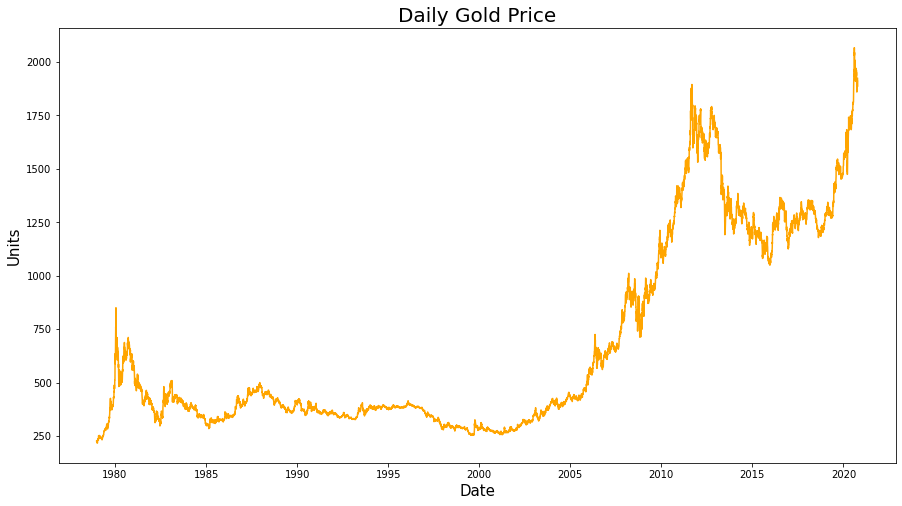

In [14]:
plt.plot(df,color='orange')
plt.title('Daily Gold Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [15]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [30]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['USD'] = df['USD'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [31]:
#Split data set into testing dataset and train dataset
train_size = 9801
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [18]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(9797, 4)
(9797,)
(1096, 4)
(1096,)


In [19]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [20]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 7)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 256,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling="log")),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_2')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 7, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=500,
             batch_size=32,
             validation_data=(testX, testY))

Trial 9 Complete [00h 09m 58s]
val_mae: 0.4138053357601166

Best val_mae So Far: 0.0039410823956131935
Total elapsed time: 01h 15m 52s

Search: Running Trial #10

Hyperparameter    |Value             |Best Value So Far 
num_layers        |2                 |1                 
units_0           |96                |216               
dropout           |True              |False             
learning_rate     |0.0011598         |0.01779           
units_1           |248               |128               
Dropout_rate      |0.5               |0.4               
units_2           |40                |256               
units_3           |16                |168               
units_4           |256               |24                
units_5           |136               |8                 
units_6           |136               |None              

Epoch 1/500
307/307 [==============================] - 2s 3ms/step - loss: 0.0391 - mae: 0.0391 - val_loss: 0.1963 - val_mae: 0.1963
Epoch 2/500
307/307

In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_2
Showing 10 best trials
Objective(name='val_mae', direction='min')
Trial summary
Hyperparameters:
num_layers: 1
units_0: 216
dropout: False
learning_rate: 0.017789995544369677
units_1: 128
Dropout_rate: 0.4
units_2: 256
units_3: 168
units_4: 24
units_5: 8
Score: 0.0039410823956131935
Trial summary
Hyperparameters:
num_layers: 5
units_0: 232
dropout: False
learning_rate: 2.897205061135355e-05
units_1: 72
Dropout_rate: 0.1
units_2: 112
units_3: 16
units_4: 64
units_5: 224
units_6: 104
Score: 0.003952597733587027
Trial summary
Hyperparameters:
num_layers: 7
units_0: 88
dropout: False
learning_rate: 1.2520169936288927e-05
units_1: 88
Dropout_rate: 0.1
units_2: 24
units_3: 80
units_4: 88
units_5: 152
units_6: 8
Score: 0.003953000996261835
Trial summary
Hyperparameters:
num_layers: 2
units_0: 80
dropout: False
learning_rate: 0.009361196114516681
units_1: 8
Score: 0.003975283354520798
Trial summary
Hyperparameters:
num_layers: 4
units_0: 40
dropout: 

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 216)               1080      
                                                                 
 dense_1 (Dense)             (None, 1)                 217       
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [21]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
model = Sequential()
model.add(Dense(8,activation='relu',input_dim = 4))
model.add(Dense(4,activation='relu'))
model.add(Dense(2,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.0000057789995544369677)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 32, epochs = 700)

Epoch 1/700
307/307 [==============================] - 2s 4ms/step - loss: 48.9038 - mape: 48.9038 - val_loss: 48.8500 - val_mape: 48.8500
Epoch 2/700
307/307 [==============================] - 1s 2ms/step - loss: 43.7285 - mape: 43.7285 - val_loss: 46.2047 - val_mape: 46.2047
Epoch 3/700
307/307 [==============================] - 1s 2ms/step - loss: 38.4965 - mape: 38.4965 - val_loss: 43.5233 - val_mape: 43.5233
Epoch 4/700
307/307 [==============================] - 1s 2ms/step - loss: 33.2081 - mape: 33.2081 - val_loss: 40.8059 - val_mape: 40.8059
Epoch 5/700
307/307 [==============================] - 1s 2ms/step - loss: 27.8682 - mape: 27.8682 - val_loss: 38.0568 - val_mape: 38.0568
Epoch 6/700
307/307 [==============================] - 1s 2ms/step - loss: 22.4716 - mape: 22.4716 - val_loss: 35.2741 - val_mape: 35.2741
Epoch 7/700
307/307 [==============================] - 1s 2ms/step - loss: 17.2990 - mape: 17.2990 - val_loss: 32.6382 - val_mape: 32.6382
Epoch 8/700
307/307 [======

In [33]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [34]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.13 
Test MAPE : 0.85 


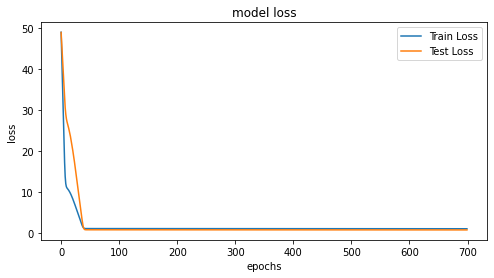

In [35]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [27]:
import seaborn as sns

In [28]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(9797,10893)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

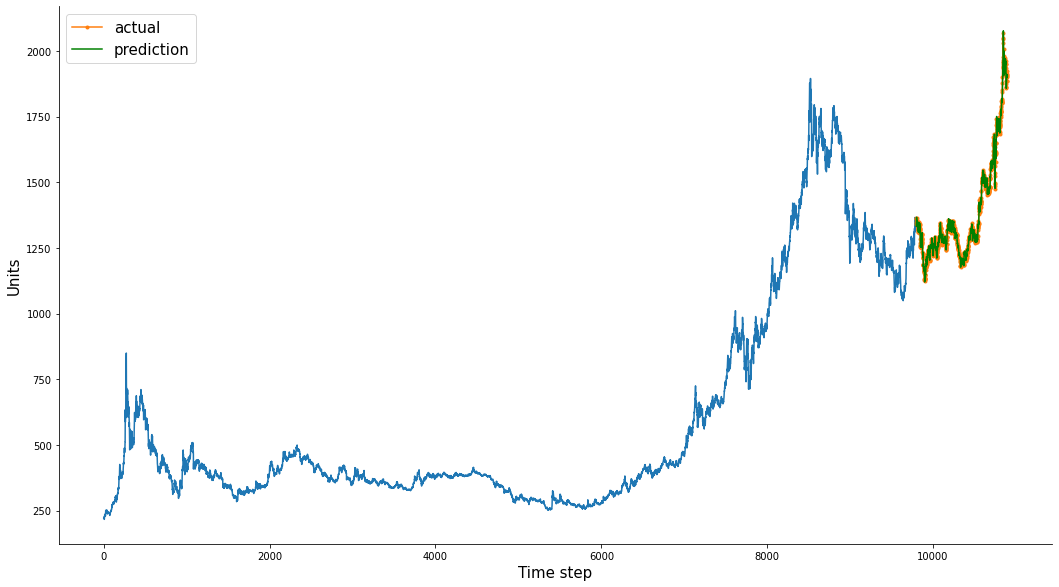

In [36]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)